In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2

In [2]:
image_dir = 'mask_dataset/train'
data=[]
labels=[]
image_paths = os.listdir(image_dir)

for dirName in image_paths:
    dirPath = os.path.join(image_dir, dirName)
    images = os.listdir(dirPath)
    for img in images:
        face = load_img(os.path.join(dirPath, img), target_size=(224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        data.append(face)
        labels.append(dirName)



C:\Users\laxman\miniconda3\envs\majorproject\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [3]:
data = np.array(data, dtype='float32')
labels = np.array(labels, dtype='str')

In [4]:
data.shape

(15260, 224, 224, 3)

In [5]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [6]:
labels.shape

(15260, 2)

In [7]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [8]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [9]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [10]:
print(baseModel.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [11]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [12]:
for layer in baseModel.layers:
    layer.trainable=False


print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [13]:
learning_rate=0.001
Epochs = 20
BS=16

In [14]:
opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [15]:
H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)

Epoch 1/20
763/763 [==============================] - 3588s 5s/step - loss: 0.1396 - accuracy: 0.9477 - val_loss: 0.0482 - val_accuracy: 0.9833
Epoch 2/20
763/763 [==============================] - 1271s 2s/step - loss: 0.0897 - accuracy: 0.9672
Epoch 3/20
763/763 [==============================] - 773s 1s/step - loss: 0.0752 - accuracy: 0.9731
Epoch 4/20
763/763 [==============================] - 749s 982ms/step - loss: 0.0684 - accuracy: 0.9774
Epoch 5/20
763/763 [==============================] - 629s 825ms/step - loss: 0.0670 - accuracy: 0.9767
Epoch 6/20
763/763 [==============================] - 780s 1s/step - loss: 0.0604 - accuracy: 0.9786
Epoch 7/20
763/763 [==============================] - 729s 955ms/step - loss: 0.0592 - accuracy: 0.9789
Epoch 8/20
763/763 [==============================] - 555s 727ms/step - loss: 0.0570 - accuracy: 0.9796
Epoch 9/20
763/763 [==============================] - 747s 979ms/step - loss: 0.0543 - accuracy: 0.9803
Epoch 10/20
763/763 [===========

In [16]:
del data
del labels

In [17]:
model.save('mobilenet_v2.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mobilenet_v2.model\assets


In [18]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99      1550
without_mask       0.99      0.99      0.99      1502

    accuracy                           0.99      3052
   macro avg       0.99      0.99      0.99      3052
weighted avg       0.99      0.99      0.99      3052



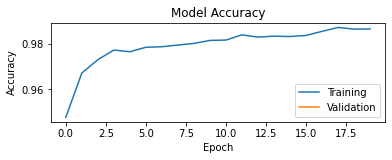

In [20]:
N = Epochs
plt.subplot(211)
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

In [19]:
del train_X
del train_Y

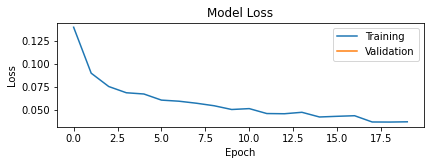

In [21]:
plt.subplot(212)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
test_Y.shape

(3052, 2)

In [24]:
predict.shape

(3052,)

In [25]:
pred = to_categorical(predict)

In [26]:
pred.shape

(3052, 2)

In [27]:
pred.argmax(axis=1)

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [28]:
test_Y.argmax(axis=1)

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [29]:
conf_mat = confusion_matrix(test_Y.argmax(axis=1), pred.argmax(axis=1))

<AxesSubplot:>

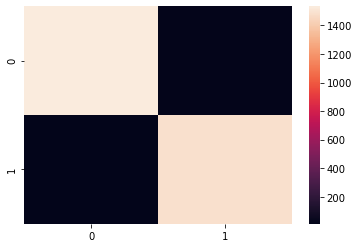

In [30]:
import seaborn as sns
sns.heatmap(conf_mat)

In [31]:
test_X[0].shape

(224, 224, 3)

In [36]:
image_dir = 'mask_dataset/test'
data=[]
labels=[]
image_paths = os.listdir(image_dir)

for dirName in image_paths:
    dirPath = os.path.join(image_dir, dirName)
    images = os.listdir(dirPath)
    for img in images:
        face = load_img(os.path.join(dirPath, img), target_size=(224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        data.append(face)
        labels.append(dirName)

In [37]:
data = np.array(data, dtype='float32')
labels = np.array(labels, dtype='str')

In [38]:
data.shape

(1106, 224, 224, 3)

In [39]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [40]:
labels.shape

(1106, 2)

In [42]:
test_pred = model.predict(data, batch_size=BS)

In [43]:
test_pred.shape

(1106, 2)

In [67]:
tp = []
for i in test_pred:
    tp.append(np.argmax(i))

In [55]:
tp = np.where(test_pred==1)[1]

In [69]:
lb = np.where(labels==1)[1]

In [76]:
print(classification_report(lb,tp))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       553
           1       0.98      0.99      0.99       553

    accuracy                           0.99      1106
   macro avg       0.99      0.99      0.99      1106
weighted avg       0.99      0.99      0.99      1106



<AxesSubplot:>

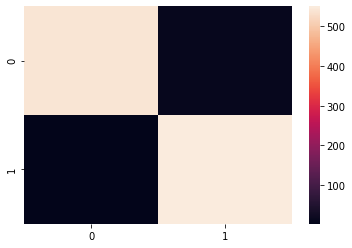

In [77]:
conf_mat = confusion_matrix(lb, tp)
sns.heatmap(conf_mat)